# **0. Datos del grupo e Importación del dataset**

## 1.1 Datos del grupo y enlace al repositorio de Github

Esta práctica ha sido realizada por el **Grupo 5**, formado por:
* Izan Sánchez Álvado (NIA: 100495774)
* Alba Tello Marcos (NIA: 100495755)

El código completo con los respectivos commits se encuentra en el siguiente repositorio de GitHub:
https://github.com/albatellouc3m/Grupo5


## 1.2 Importación del dataset

In [36]:
import pandas as pd

datos_generales = pd.read_csv('./semillas.csv')

X = datos_generales.iloc[:, :-1].values  # Todas las columnas menos la última
y = datos_generales.iloc[:, -1].values   # La última columna

datos_generales.head()

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


# **1. Comprobación de scalers visualmente utilizando PCA**

Primero realizamos una importación de los datos para la práctica y los representamos para estudiarlos

In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


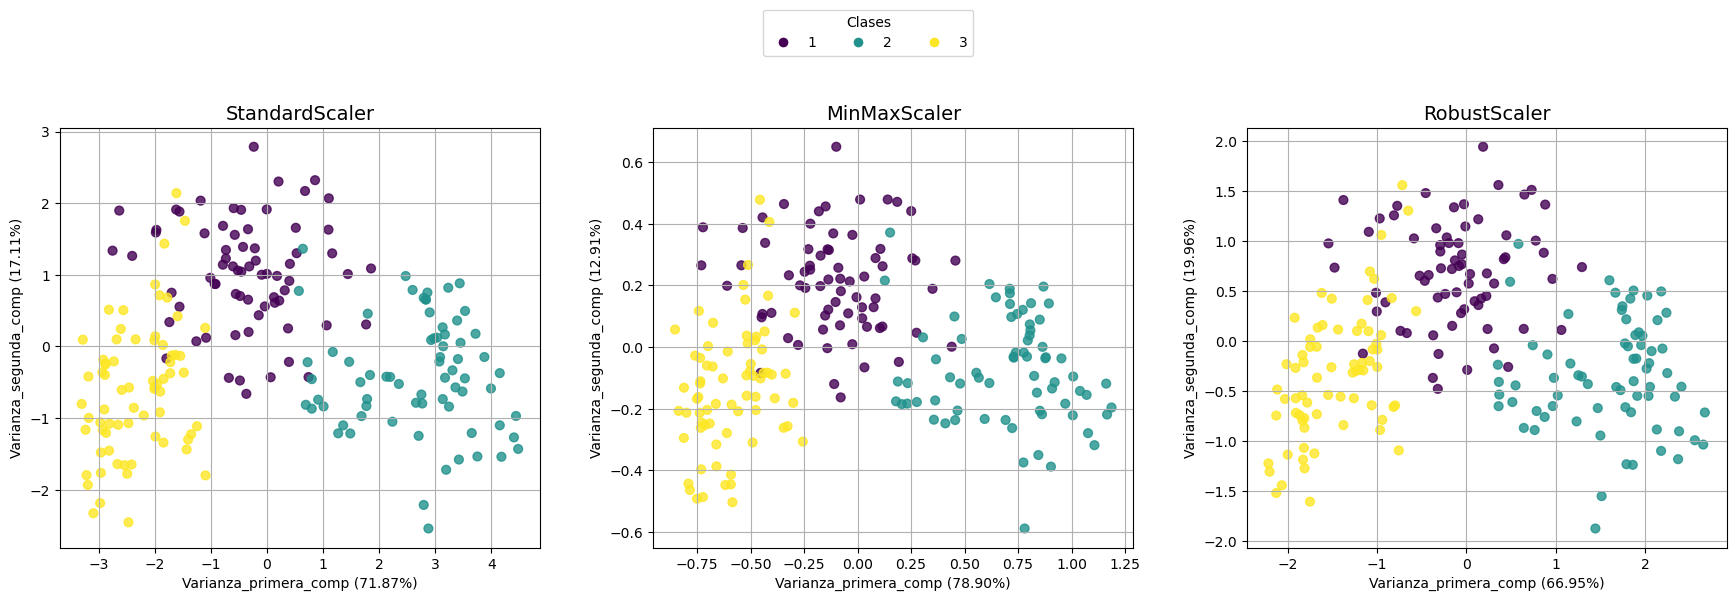

In [38]:
# MÉTODOS DE ESCALADO
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas

for idx, (nombre, scaler) in enumerate(scalers.items()):
    
    # Escalamos los datos
    X_scaled = scaler.fit_transform(X)
    
    # Aplicamos PCA
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X_scaled)

    # Visualizamos en 2D
    scatter = axes[idx].scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        c=pd.factorize(y)[0],
        cmap='viridis',
        s=40,
        alpha=0.8
    )
    
    axes[idx].set_title(f"{nombre}", fontsize=14)
    axes[idx].set_xlabel("Varianza_primera_comp ({:.2f}%)".format(pca.explained_variance_ratio_[0]*100))
    axes[idx].set_ylabel("Varianza_segunda_comp ({:.2f}%)".format(pca.explained_variance_ratio_[1]*100))
    axes[idx].grid(True)

# Leyenda común
etiquetas = sorted(set(y))
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=etiqueta,
               markerfacecolor=plt.cm.viridis(i / (len(etiquetas)-1)), markersize=8)
    for i, etiqueta in enumerate(etiquetas)
]

# Ajustamos la leyenda para separarla del gráfico
fig.legend(handles=handles, title="Clases", loc="upper center", ncol=len(etiquetas), fontsize=10, bbox_to_anchor=(0.5, 1.05))

# Ajustamos el layout para más espacio en la parte superior
plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])  # Mayor espacio entre el gráfico y la leyenda
plt.show()


Viendo estos gráficos, podemos llegar a la conclusión de que MinMax es el mejor scaler ya que la varianza es más alta en este. Por ello, para el resto del código, utilizaremos una reducción con el scaler MinMaxScaler

In [39]:

# REDUCCIÓN DE DIMENSIONALIDAD CON PIPELINE MINMAX
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Usamos MinMaxScaler ya elegido anteriormente
    ('pca', PCA(n_components=2))
])

# Transformamos los datos
X_reduced = pipeline.fit_transform(X)
pca = pipeline.named_steps['pca']

# Convertimos X_reduced a DataFrame para visualización
df_reduced = pd.DataFrame(X_reduced, columns=['X1', 'X2'])

# Mostrar las primeras filas
print(df_reduced.head())  # Puedes usar df_reduced.head() para ver las primeras 5 filas


         X1        X2
0  0.075029  0.129691
1 -0.024301  0.364120
2 -0.149375  0.456497
3 -0.180881  0.440557
4  0.250589  0.441297


# **2. Aplicación de técnicas de clustering (K-Means, Dendogramas, DBSCAN)**

En esta sección, como el nombre indica, aplicaremos las técnicas estudiadas en clase sobre clustering comparandolas y sacando conclusiones

## 2.1. K-Means

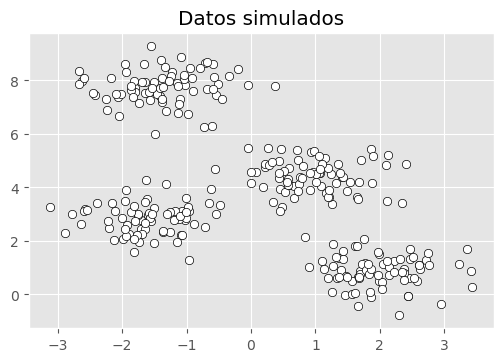

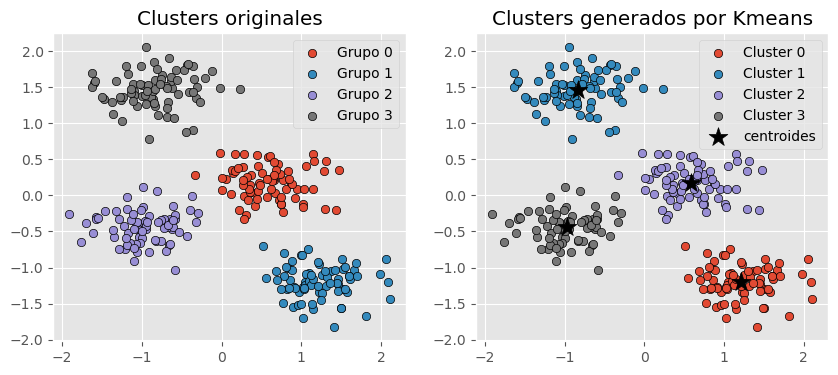

In [40]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Simulación de datos
# ==============================================================================
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados');

# Escalado de datos
# ==============================================================================
X_scaled = scale(X)

# Modelo
# ==============================================================================
modelo_kmeans = KMeans(n_clusters=4, n_init=25, random_state=42)
modelo_kmeans.fit(X=X_scaled)

# Clasificación con el modelo kmeans
# ==============================================================================
y_predict = modelo_kmeans.predict(X=X_scaled)

# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();